# Basin gcm processing

What we want to do here:
- Download gcm data.
- Fetch shapefile for a basin.
- Select gridpoints from gcm data that are within this shapefile.
- Bias correct them. Inspiration from the OGGM.
- Take a mean of temperature of these gridpoints. 
- Total of precipitation?

In [3]:
import xarray as xr
import numpy as np
import geopandas as gpd
import shapely.geometry as shpg
from matplotlib import pyplot as plt
import pandas as pd
from oggm import utils
import zipfile

## Downloading the data

We need the cmip5 data, and the reference data (CRU).

In [4]:
def download_proj_data(rcps):
    '''
    Small helper function to download data.
    
    Args
    rcps: List of rcp scenarios.
    
    Returns
    fts: List of temperature files
    fps: List of precipitation files
    '''
    # Base file paths
    # Note that these dont contain any scenario data.
    bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-'+\
         'ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
    bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-'+\
          'ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
    # Lists for storing our paths?
    fts = [] 
    fps = []
    for rcp in rcps:
        fts.append(utils.file_downloader(bt.format(rcp)))
        fps.append(utils.file_downloader(bp.format(rcp)))
        
    return fts, fps

In [5]:
def download_clim_data():
    
    f = 'https://cluster.klima.uni-bremen.de/~oggm/climate/cru/cru_cl2.nc.zip'
    fp = utils.file_downloader(f)
    with zipfile.ZipFile(fp, 'r') as zip_ref:
        zip_ref.extractall(fp[:-7])
    return fp[:-7] + '/cru_cl2.nc'

In [6]:
# Projection data
fts, fps = download_proj_data(['rcp26'])

In [7]:
# Reference climate data
f_cru = download_clim_data()

In [8]:
f_cru

'/home/erik/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/cru/cru_cl2/cru_cl2.nc'

Take a look at the data

In [9]:
with xr.open_dataset(fts[0]) as ds:
    ds_t = ds.isel(time=slice(0, -1)).load()
    
ds_t

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 2771)
Coordinates:
  * time     (time) datetime64[ns] 1870-01-15T12:00:00 1870-02-15 ... NaT NaT
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    tas      (time, lat, lon) float32 245.1 245.3 245.2 ... 248.1 248.2 248.2
Attributes:
    source_model:        CCSM4
    source_ensemble:     r1i1p1
    source_experiment:   historical,rcp26
    source_institution:  NCAR (National Center for Atmospheric Research) Boul...
    source_contact:      cesm_data@ucar.edu
    source_files:        tas_Amon_CCSM4_historical_r1i1p1_185001-200512.nc,ta...
    source_md5:          c8af45130a67bedc14271fa5613d27b2,56edb5417f4c8d1a8b2...
    freq:                monthly
    interpolation_grid:  2.5 x 2.5 degrees bilinear interpolation
    contact:             cmip5-archive@env.ethz.ch
    modifications:       nothing

In [10]:
# Take a look at the CRU data.
with xr.open_dataset(f_cru) as ds:
    ds_cru = ds.load()

ds_cru

<xarray.Dataset>
Dimensions:  (lat: 877, lon: 2160, month: 12)
Coordinates:
  * lat      (lat) float64 85.25 85.08 84.92 84.75 ... -60.42 -60.58 -60.75
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.7 179.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    elev     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    temp     (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    prcp     (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:        CRU CL v2.0 data - converted to NetCDF by F. Maussion
    source:       https://crudata.uea.ac.uk/cru/data/hrg/tmc/
    info:         10-minute dataset of mean monthly surface climate over glob...
    date:         2016-03-01
    data_author:  Mark New (1,*), David Lister (2), Mike Hulme (3), Ian Makin...
    file_author:  fabien.maussion@uibk.ac.at

## Shapefile and selection


In [11]:
# Continue playing with Rofental
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

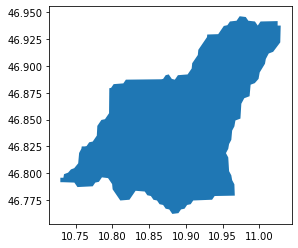

In [12]:
basin.plot();

<ipython-input-13-d2259d80e863>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  basin.centroid.plot(ax=ax, c='C1');


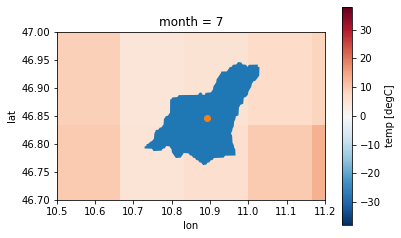

In [13]:
fig, ax = plt.subplots()
ds_cru.temp.isel(month=6).plot(ax=ax)
basin.plot(ax=ax)
ax.set_xlim(10.5, 11.2)
ax.set_ylim(46.7, 47);
basin.centroid.plot(ax=ax, c='C1');

<ipython-input-14-0bccdcf452ba>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  basin.centroid.plot(ax=ax, c='C1');


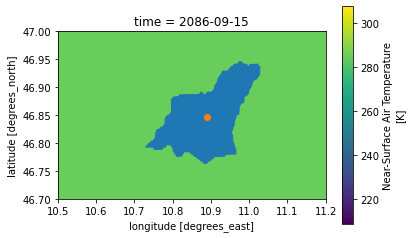

In [14]:
fig, ax = plt.subplots()
ds_t.tas.isel(time=2600).plot(ax=ax)
basin.plot(ax=ax)
ax.set_xlim(10.5, 11.2)
ax.set_ylim(46.7, 47)
basin.centroid.plot(ax=ax, c='C1');

Plot the selected grid points. Basically the four corner pieces.

Lets try it with another basin

In [15]:
gdf = gpd.read_file('./data/glacier_basins.shp')

In [72]:
def select_basin_data(df, basin):
    df_sel = df.salem.roi(shape=basin)
    
    # If selection didn't return anything, expect the basin to be too small
    
    last_var = list(df_sel.variables.items())[0][0]
    if np.all(np.isnan(df_sel[last_var].values)):
        lon = basin.geometry.centroid.x
        lat = basin.geometry.centroid.y
        # We then select the point closest to the center of the basin.
        df_sel = df.sel(lon=lon, lat=lat, method='nearest')
    return df_sel

Works for large basins

In [73]:
df_sel = select_basin_data(ds_cru, gdf.loc[[15]])

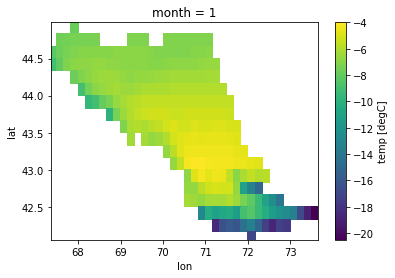

In [75]:
fig, ax = plt.subplots()
df_sel.temp.sel(month=1).plot()
minx, miny, maxx, maxy = gdf.loc[[15]].geometry.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy);

And smaller basins

In [76]:
df_sel = select_basin_data(ds_cru, basin)

<ipython-input-72-f41272846759>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = basin.geometry.centroid.x
<ipython-input-72-f41272846759>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = basin.geometry.centroid.y


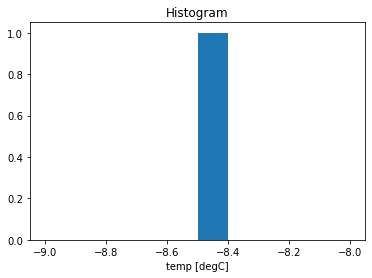

In [77]:
fig, ax = plt.subplots()
df_sel.temp.sel(month=1).plot();

**GCM data**

In [78]:
df_sel = select_basin_data(ds_t, gdf.loc[[15]])

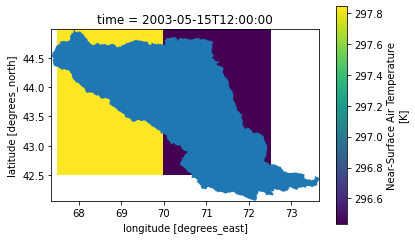

In [80]:
fig, ax = plt.subplots()
df_sel.tas.isel(time=1600).plot(ax=ax)
gdf.loc[[15]].geometry.plot(ax=ax)
minx, miny, maxx, maxy = gdf.loc[[15]].geometry.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy);

In [81]:
df_sel = select_basin_data(ds_t, basin)

<ipython-input-72-f41272846759>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = basin.geometry.centroid.x
<ipython-input-72-f41272846759>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = basin.geometry.centroid.y


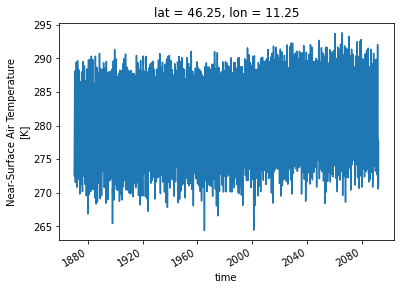

In [83]:
fig, ax = plt.subplots()
df_sel.tas.plot(ax=ax);